# Forecasting beer sales 

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html


- https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/
- https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/


## Install

In [779]:
# !pip install numpy
# !pip install pandas

# !pip install python-dotenv
# !pip install pyodbc

# !pip install sklearn
# !pip install joblib
# !pip install optuna

# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

# !pip install matplotlib
# !pip install seaborn
# !pip install rfpimp
# !pip install skater
# !pip install eli5
# !pip install pandas-profiling
# !pip install ipywidgets

## Init

In [780]:
import pandas as pd
import numpy as np
import os
import datetime

import pyodbc
from dotenv import load_dotenv

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance
from pandas_profiling import ProfileReport

from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [781]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [782]:
load_dotenv()

True

In [783]:
DATASET_MARKET = 'on-trade'
DATASET_COUNTRY = 'all'

DATASET_NAME = f'{DATASET_MARKET}_{DATASET_COUNTRY}'

if (DATASET_MARKET == 'on-trade'):
    DATASET_FROM_YEAR = 2016
    DATASET_FROM_WEEK = 1
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 24

if (DATASET_MARKET == 'off-trade'):
    DATASET_FROM_YEAR = 2019
    DATASET_FROM_WEEK = 1
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 24


DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./train_results/{DATASET_NAME}_train_result.csv'
RESULT_EXCEL_PATH = f'./train_results/{DATASET_NAME}_train_result.xlsx'

MAX_N_JOBS = 8

TRAIN_TO_YEAR = 2021
TRAIN_TO_WEEK = 15

## Load Data

In [784]:
try:
    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    cnxn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}') 

    country_par = 'NULL' if DATASET_COUNTRY == 'all' else DATASET_COUNTRY
    query1=f'EXEC [dbo].[ML_Table_extension_data] @Country={country_par}, @FromYear={DATASET_FROM_YEAR}, @FromWeek={DATASET_FROM_WEEK}, @ToYear={DATASET_TO_YEAR}, @ToWeek={DATASET_TO_WEEK}, @Market="{DATASET_MARKET.upper()}"'
    
    data = pd.read_sql(query1, cnxn)

    data.to_csv(DATA_PATH, index=False)
except:
    print("Unexpected error:", sys.exc_info()[0])
    data = pd.read_csv(DATA_PATH, header=0)
else:
    cnxn.close()

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])    
data.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890
1,01000,PILSNER URQUELL,SK,2016,1,4,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,227.634836,240.00,NaN,NaN,NaN,NaN,155.0000
2,01002,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472
3,01002,PILSNER URQUELL,SK,2016,1,4,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,71.895601,49.80,NaN,NaN,NaN,NaN,29.9165
4,01003,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085


In [785]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  1.62 Mb (61.5% reduction)


In [786]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27439 entries, 0 to 27438
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SkuShort            27439 non-null  object 
 1   Brand               27439 non-null  object 
 2   Country             27439 non-null  object 
 3   Year                27439 non-null  int16  
 4   Week                27439 non-null  int8   
 5   NumberWorkdays      27439 non-null  int8   
 6   PrevNumberWorkdays  27348 non-null  float16
 7   NextNumberWorkdays  27439 non-null  int8   
 8   AvgTemp             27439 non-null  float16
 9   AvgRain             27439 non-null  float16
 10  AvgSun              27439 non-null  float16
 11  IsLockdown          27439 non-null  bool   
 12  PdtHl               526 non-null    float16
 13  PrevWeekPdtHl1      526 non-null    float16
 14  BgtHl               24429 non-null  float16
 15  SalesHl             24523 non-null  float64
 16  Prev

In [787]:
data.describe()

,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,27439.000000,27439.000000,27439.000000,2.734800e+04,27439.000000,2.743900e+04,27439.000000,2.743900e+04,526.000000,526.000000,2.442900e+04,24523.000000,2.427000e+04,2.410900e+04,1.946000e+04,1.470100e+04,2.386000e+04
mean,2018.256350,25.717009,4.789242,inf,4.791829,inf,1.655273,inf,50.156250,50.156250,inf,646.299836,inf,inf,inf,inf,inf
std,1.575387,14.982245,0.493052,5.009766e-01,0.492118,7.703125e+00,1.636719,3.037109e+00,inf,inf,inf,1499.138985,inf,inf,inf,inf,inf
min,2016.000000,1.000000,2.000000,2.000000e+00,2.000000,-8.281250e+00,0.000000,1.428223e-01,0.300049,0.300049,5.960464e-08,0.050000,4.998779e-02,4.998779e-02,4.998779e-02,3.000488e-01,5.319214e-02
25%,2017.000000,13.000000,5.000000,5.000000e+00,5.000000,4.000000e+00,0.471436,2.185547e+00,3.386719,3.386719,4.768750e+01,35.400000,3.631250e+01,3.659375e+01,4.381250e+01,4.793750e+01,3.934375e+01
50%,2018.000000,25.000000,5.000000,5.000000e+00,5.000000,1.046875e+01,1.128906,4.792969e+00,14.179688,14.179688,1.712500e+02,135.000000,1.370000e+02,1.380000e+02,1.632500e+02,1.812500e+02,1.485000e+02
75%,2020.000000,39.000000,5.000000,5.000000e+00,5.000000,1.768750e+01,2.271484,7.144531e+00,34.375000,34.375000,5.760000e+02,512.850000,5.155000e+02,5.165000e+02,5.725000e+02,5.990000e+02,5.280000e+02
max,2021.000000,53.000000,5.000000,5.000000e+00,5.000000,2.581250e+01,7.957031,1.386719e+01,625.000000,625.000000,1.460000e+04,17816.500000,1.782400e+04,1.782400e+04,1.782400e+04,1.782400e+04,1.504800e+04


## Missing Values

In [788]:
data.isna().sum()

SkuShort              0    
Brand                 0    
Country               0    
Year                  0    
Week                  0    
NumberWorkdays        0    
PrevNumberWorkdays    91   
NextNumberWorkdays    0    
AvgTemp               0    
AvgRain               0    
AvgSun                0    
IsLockdown            0    
PdtHl                 26913
PrevWeekPdtHl1        26913
BgtHl                 3010 
SalesHl               2916 
PrevWeekSalesHl1      3169 
PrevWeekSalesHl2      3330 
PrevYearSalesHl1      7979 
PrevYearSalesHl2      12738
OldPredSalesHl        3579 
dtype: int64

## Data Visualizations

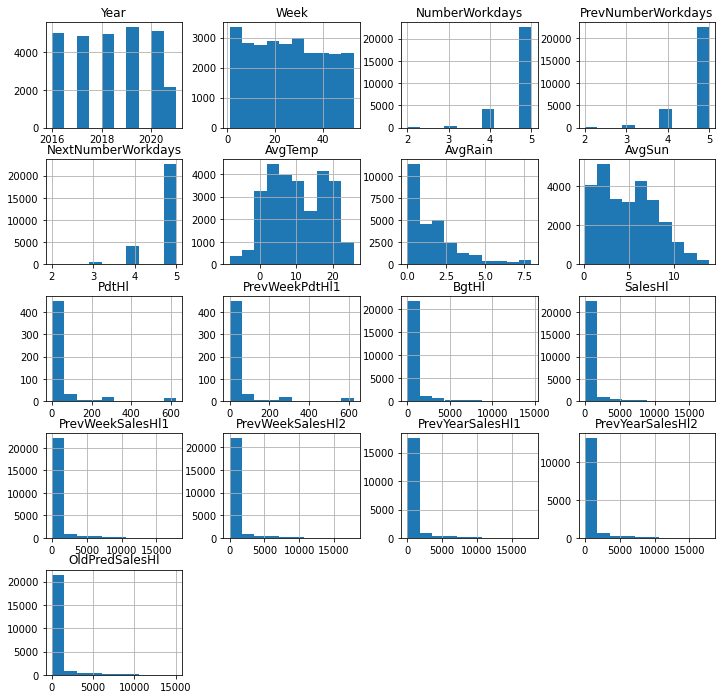

In [789]:
data.hist(figsize=[12,12])
plt.show()

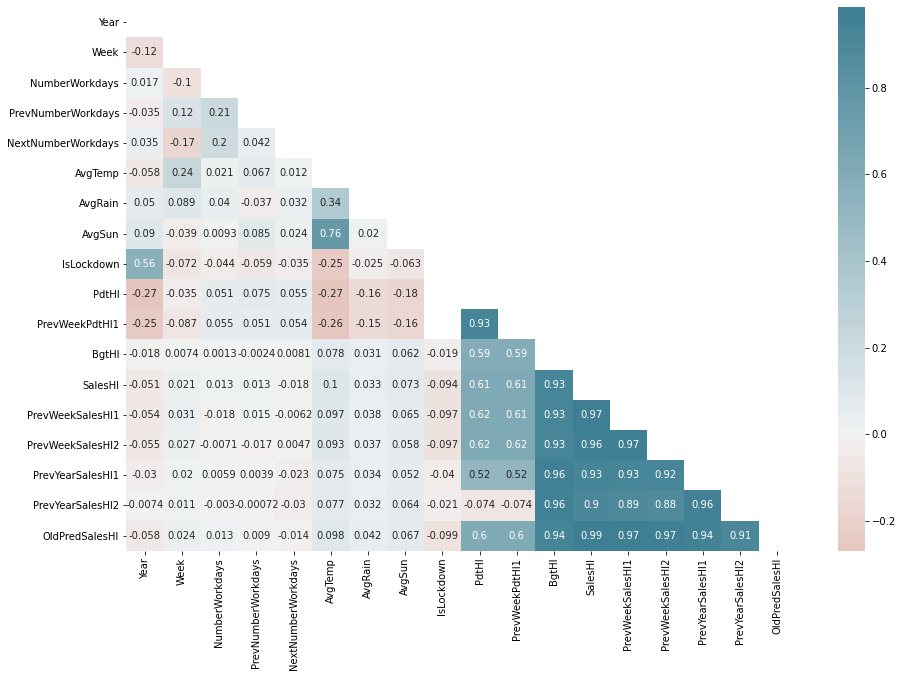

In [790]:
plt.subplots(figsize = (15,10))
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [791]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.986064
PrevWeekSalesHl1,0.972606
PrevWeekSalesHl2,0.963176
PrevYearSalesHl1,0.934875
BgtHl,0.931478
PrevYearSalesHl2,0.904542
PdtHl,0.612812
PrevWeekPdtHl1,0.612127
AvgTemp,0.099775


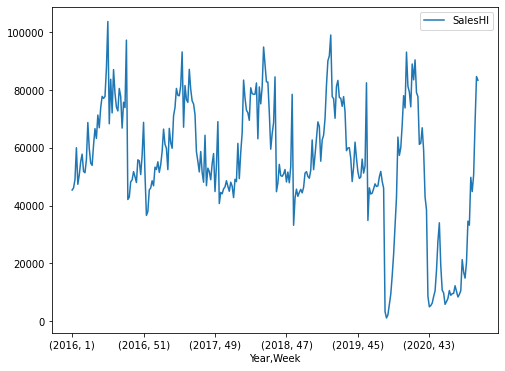

In [792]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

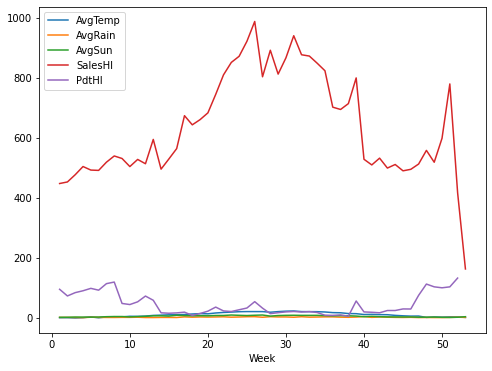

In [793]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

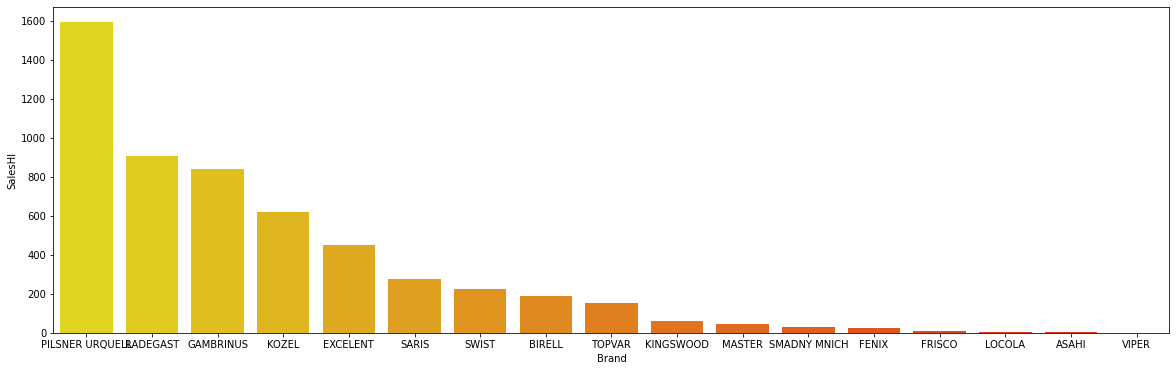

In [794]:
plt.figure(figsize=(20,6))
g_pps = data.groupby('Brand')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('Brand')
axis.set_ylabel('SalesHl')

plt.show()

## Skewness and Kurtesis

In [795]:
data.skew()

SkuShort              1.804895
Year                  0.056379
Week                  0.085803
NumberWorkdays       -2.671343
PrevNumberWorkdays   -inf     
NextNumberWorkdays   -2.704905
AvgTemp              -inf     
AvgRain               inf     
AvgSun                inf     
IsLockdown            2.091118
PdtHl                 3.875000
PrevWeekPdtHl1        3.875000
BgtHl                 inf     
SalesHl               4.243672
PrevWeekSalesHl1      inf     
PrevWeekSalesHl2      inf     
PrevYearSalesHl1      inf     
PrevYearSalesHl2      inf     
OldPredSalesHl        inf     
dtype: float64

In [796]:
data.kurt()

SkuShort              4.185648 
Year                 -1.154129 
Week                 -1.181763 
NumberWorkdays        8.247936 
PrevNumberWorkdays   NaN       
NextNumberWorkdays    8.439643 
AvgTemp              NaN       
AvgRain              NaN       
AvgSun               NaN       
IsLockdown            2.372949 
PdtHl                NaN       
PrevWeekPdtHl1       NaN       
BgtHl                NaN       
SalesHl               20.795707
PrevWeekSalesHl1     NaN       
PrevWeekSalesHl2     NaN       
PrevYearSalesHl1     NaN       
PrevYearSalesHl2     NaN       
OldPredSalesHl       NaN       
dtype: float64

In [797]:

# profile = ProfileReport(data, minimal=True)
# profile.to_notebook_iframe()

## Spliting data in X and Y

In [798]:
cols_drop = ['SalesHl', 'OldPredSalesHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'BgtHl', 'Brand', 'SubBrand'

X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()
y_oldPred = data.OldPredSalesHl.fillna(0).to_numpy()

## LabelEncoder

In [799]:
Country_mapping = {"CZ": 1, "SK": 2}
# PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
# X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

sku_encoder = LabelEncoder()
X.SkuShort = sku_encoder.fit_transform(X.SkuShort)

brand_encoder = LabelEncoder()
X.Brand = brand_encoder.fit_transform(X.Brand)
# X.SubBrand = LabelEncoder().fit_transform(X.SubBrand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,10,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1902.000,NaN,NaN,NaN,NaN
1,0,10,2,2016,1,4,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,227.625,NaN,NaN,NaN,NaN
2,2,10,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,473.000,NaN,NaN,NaN,NaN
3,2,10,2,2016,1,4,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,71.875,NaN,NaN,NaN,NaN
4,3,10,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,3010.000,NaN,NaN,NaN,NaN


## Imputer

In [800]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)
X.PrevNumberWorkdays = X.PrevNumberWorkdays.fillna(5)
X.NextNumberWorkdays = X.NextNumberWorkdays.fillna(5)

In [801]:
imputer = SimpleImputer(strategy='mean')
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# imputer = IterativeImputer(random_state=0, skip_complete=True, min_value=0) #649.619645	
# imputer = KNNImputer()

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0.0,10.0,1.0,2016.0,1.0,5.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,1902.000000,649.619645,650.752694,709.045507,749.326224
1,0.0,10.0,2.0,2016.0,1.0,4.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,227.625000,649.619645,650.752694,709.045507,749.326224
2,2.0,10.0,1.0,2016.0,1.0,5.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,473.000000,649.619645,650.752694,709.045507,749.326224
3,2.0,10.0,2.0,2016.0,1.0,4.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,71.875000,649.619645,650.752694,709.045507,749.326224
4,3.0,10.0,1.0,2016.0,1.0,5.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,3010.000000,649.619645,650.752694,709.045507,749.326224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27434,117.0,6.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,4.195312,649.619645,650.752694,709.045507,18.359375
27435,120.0,16.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,0.000000,649.619645,650.752694,709.045507,749.326224
27436,121.0,14.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,204.250000,179.000000,134.000000,138.000000,259.500000
27437,122.0,14.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,669.500000,685.000000,375.000000,320.500000,835.000000


## Adding a New Feature

In [802]:
#Avg 
# X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)


X = X.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2', 'PrevYearSalesHl1', 'PrevYearSalesHl2'], axis=1)

X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,10.0,1.0,2016.0,1.0,5.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,1902.000000,729.2,689.7
1,0.0,10.0,2.0,2016.0,1.0,4.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,227.625000,729.2,689.7
2,2.0,10.0,1.0,2016.0,1.0,5.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,473.000000,729.2,689.7
3,2.0,10.0,2.0,2016.0,1.0,4.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,71.875000,729.2,689.7
4,3.0,10.0,1.0,2016.0,1.0,5.0,4.78514,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,3010.000000,729.2,689.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27434,117.0,6.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,4.195312,363.7,506.9
27435,120.0,16.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,0.000000,729.2,689.7
27436,121.0,14.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,204.250000,198.8,177.6
27437,122.0,14.0,1.0,2021.0,24.0,5.0,5.00000,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,669.500000,577.8,553.9


## Split train and test

In [803]:
train_index = len(X[(X.Year <= TRAIN_TO_YEAR-1) | ((X.Year == TRAIN_TO_YEAR) & (X.Week < TRAIN_TO_WEEK))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)
 
X_train = X.iloc[:train_index]
y_train = y[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y[train_index:]
y_test_oldPred = y_oldPred[train_index:]

## Scaler

In [804]:
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
scaler = StandardScaler() 
# scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,-1.621878,0.570809,-0.959387,-1.425697,-1.641227,0.436407,0.008524,0.431838,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,0.887868,-0.001537,-0.002529
1,-1.621878,0.570809,1.042332,-1.425697,-1.641227,-1.563231,0.008524,0.431838,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,-0.275221,-0.001537,-0.002529
2,-1.561486,0.570809,-0.959387,-1.425697,-1.641227,0.436407,0.008524,0.431838,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,-0.104773,-0.001537,-0.002529
3,-1.561486,0.570809,1.042332,-1.425697,-1.641227,-1.563231,0.008524,0.431838,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,-0.383411,-0.001537,-0.002529
4,-1.531291,0.570809,-0.959387,-1.425697,-1.641227,0.436407,0.008524,0.431838,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,1.657530,-0.001537,-0.002529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26493,1.850646,-0.483237,-0.959387,1.876182,-0.785483,-1.563231,-1.544633,0.431838,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.413074,-0.602852,-0.559280
26494,1.880841,-0.483237,-0.959387,1.876182,-0.785483,-1.563231,-1.544633,0.431838,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.359533,-0.284780,-0.401957
26495,2.031821,1.624854,-0.959387,1.876182,-0.785483,-1.563231,-1.544633,0.431838,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.289548,-0.546203,-0.529497
26496,2.062017,1.624854,-0.959387,1.876182,-0.785483,-1.563231,-1.544633,0.431838,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.102863,-0.479064,-0.490247


## Regressors

In [805]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True)
#model = ensemble.ExtraTreesRegressor(n_jobs=3)
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
# model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
# model = linear_model.OrthogonalMatchingPursuit()
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) 
# model = linear_model.RANSACRegressor(max_trials=500)
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) 
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) 

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR()

#model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, reg_lambda=20, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

## Find best params

In [806]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart',  importance_type='gain', reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

# param_grid = dict(base_score =[ 0.25, 0.3, 0.35, 0.4,]) #importance_type=['gain', 'weight', 'cover','total_gain','total_cover']
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train)
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [807]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)#0.9168

# # Train the model using the training sets
# model.fit(X_train, y_train)

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# print(DATASET_NAME)
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
# print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
# print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
# print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

## Models

### HistGradientBoostingRegressor 

In [808]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [809]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [810]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS)

### XGBRegressor

In [811]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)

### CatBoostRegressor

In [812]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [813]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=MAX_N_JOBS)

### ExtraTreesRegressor

In [814]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [815]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, etrModel] #xgbModel
regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=8, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=8,
                       oob_score=True, random_state=0),
 ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.7, min_samples_leaf=2,
                     min_weight_fraction_leaf=0, n_estimators=200,
                     oob_score=True, warm_start=True)]

In [816]:
%%time

estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', "AbsoluteScore", 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    abs_score = absolute_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, abs_score, me, mse, mae]

    estimators.append((model_name, reg_model))

Wall time: 2min 18s


In [817]:
col_metric = 'AbsoluteScore'
max_score = result_models[col_metric].max()
min_score = result_models[col_metric].min()
min_weight = min_score - ((max_score - min_score) * 0.2)

result_models["Weights"] = result_models[col_metric].map(lambda x: round((x - min_weight) / (max_score - min_weight), 2))
result_models.sort_values(by=[col_metric], ascending=False)

,Model,Score,AbsoluteScore,ME,MSE,MAE,Weights
2,HistGradientBoostingRegressor,0.932794,0.733608,2772.295050,108777.937691,137.348689,1.00
1,CatBoostRegressor,0.934881,0.727502,2855.227398,105400.420275,140.497051,0.82
3,RandomForestRegressor,0.923310,0.722004,3340.312685,124128.566787,143.331498,0.66
0,LGBMRegressor,0.936959,0.718729,2760.442582,102035.946541,145.020347,0.56
4,ExtraTreesRegressor,0.921009,0.705364,2843.343676,127853.180373,151.910970,0.17


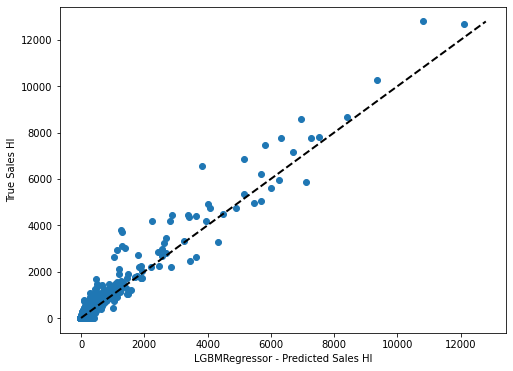

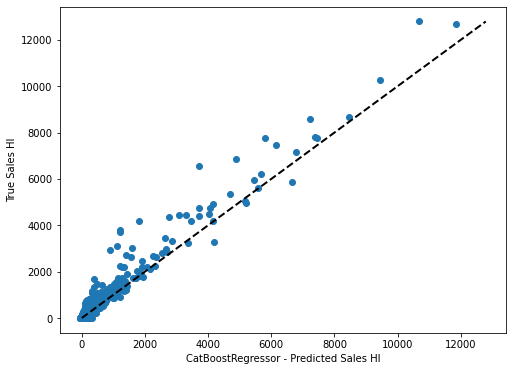

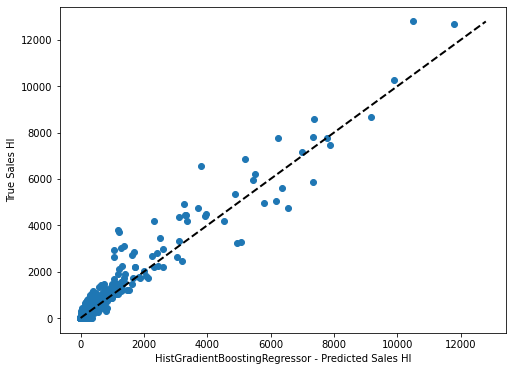

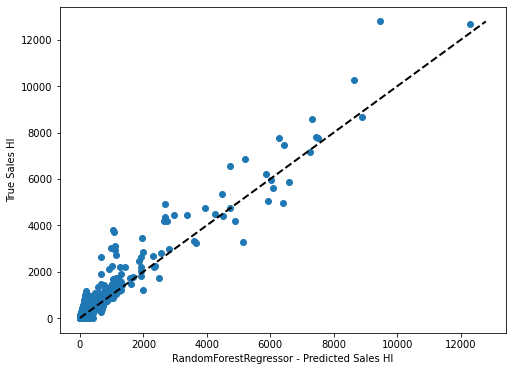

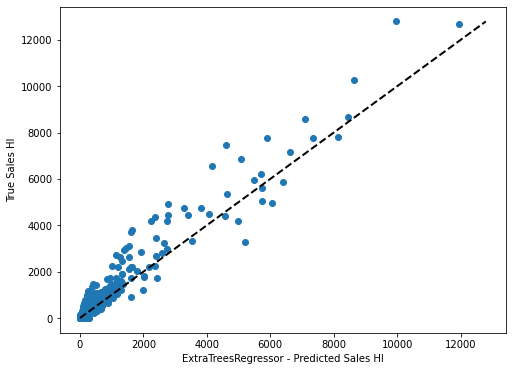

In [818]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

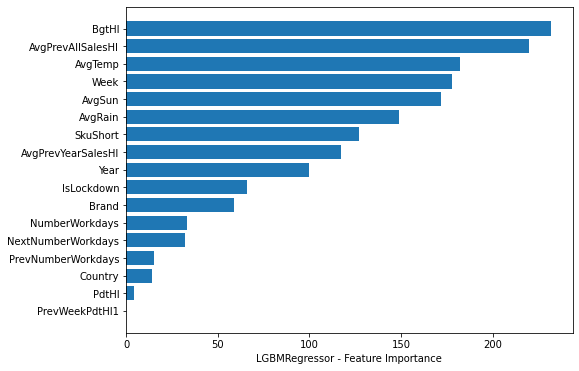

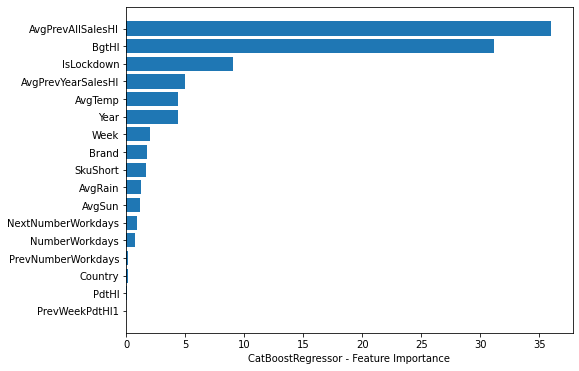

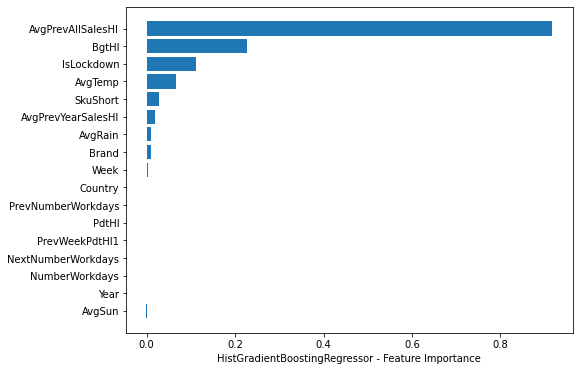

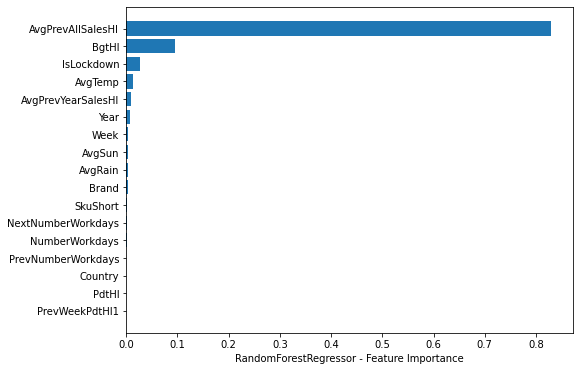

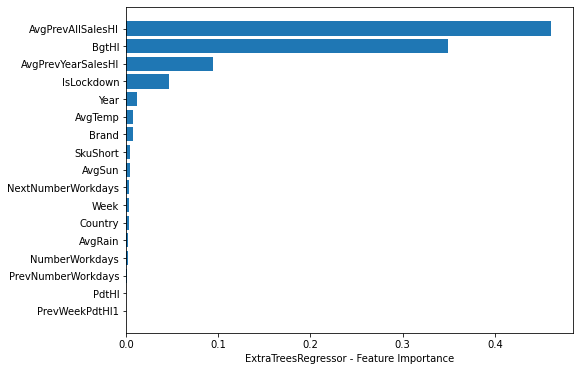

In [819]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [820]:
%%time

model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

Wall time: 2min 14s


In [821]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

print('----------------')

print('Classic Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Classic Absolute Score: %.4f'% absolute_score(y_test, y_test_oldPred))
print('Classic Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_test_oldPred))
print('Classic Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Classic Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_test_oldPred))


on-trade_all
----------------
Coefficient of determination: 0.9378
Absolute Score: 0.7404
Mean absolute error regression loss.: 133.8390
Maximum residual error: 2623.5000
Mean squared error regression loss: 100631.2842
----------------
Classic Coefficient of determination: 0.9432
Classic Absolute Score: 0.7722
Classic Mean absolute error regression loss.: 117.4669
Classic Maximum residual error: 3395.5000
Classic Mean squared error regression loss: 91932.6711


In [822]:
# on-trade_all
# ----------------
# Coefficient of determination: 0.9428
# Absolute Score: 0.7496
# Mean absolute error regression loss.: 129.1253
# Maximum residual error: 2506.0000
# Mean squared error regression loss: 92517.5312

# on-trade
# ----------------
# Coefficient of determination: 0.9582
# Absolute Score: 0.8139
# Mean absolute error regression loss.: 95.9693
# Maximum residual error: 2890.5000
# Mean squared error regression loss: 67592.0822


# off-trade
# ----------------
# Coefficient of determination: 0.8583
# Absolute Score: 0.6249
# Mean absolute error regression loss.: 224.1787
# Maximum residual error: 6374.9000
# Mean squared error regression loss: 317901.6107


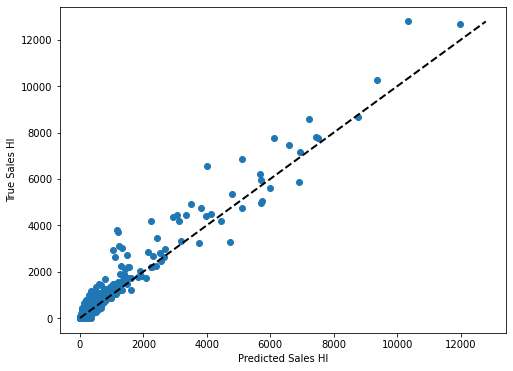

In [823]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

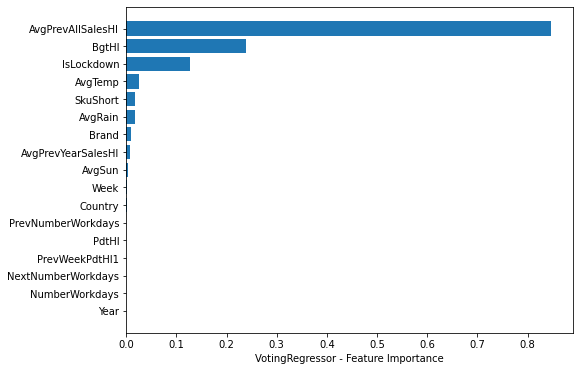

Wall time: 21.8 s


In [824]:
%%time

show_feature_importances(model, X_test, y_test)

## Save Result

In [825]:
result = X_test_raw.copy(deep=True)
result["TrueSalesHl"] = y_test
result["PredSalesHl_Classic"] = y_test_oldPred
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [826]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(imputer, IMPUTER_PATH)
joblib.dump(sku_encoder, SKU_ENCODER_PATH)
joblib.dump(brand_encoder, BRAND_ENCODER_PATH)

['./models/on-trade_all_brand_encoder.joblib']